<b>
An Evaluation of Different Machine Learning Algorithms for <br>
Predicting Academic Success Based on Given Data <br>
</b>
<br>
<b>
Mangawang, Felix <br>
Ong, Andrei <br>
Sillona, John <br>
Valero, Nigel <br>
</b>

<br>
<b> Introduction of the Problem/Task </b>

A human mind has limitations in analyzing complex data. To overcome the limitations, technological advances of humanity have enabled mankind to automate certain processes and calculations using computers as tools. To effectively and efficiently perform its tasks, a computer must undergo machine learning. Machine Learning allows computers to learn and train from algorithms to eventually execute tasks without direct instructions or programming from their users. As a result, specific tasks such as classifying, predicting, and identifying relations and patterns are completed by computers developed through machine learning (IBM, 2021). <br>
<br>
Machine learning begins with the chosen machine learning algorithm. The algorithms are the models or methods for the computer to produce its desired output data from a given input data to meet its objective. There are various types of machine learning algorithms to choose from, depending on the task assigned to the computer. For this study, logistic regression, random forest, and support vector machine are chosen to perform predictions on a supplied dataset (Hashemi-Pour & Wigmore, 2024). <br>
<br>
As students, academic success is influenced by numerous factors like choices, family background, and lifestyle (Communications Team, 2022). With these multiple factors affecting one's performance in school, it sparked an interest in testing machine learning algorithms on their accuracy to predict a student's academic success. The objective of the study is to evaluate the three selected machine learning algorithms on their differences in conducting predictions, knowing the unique processes of each algorithm when given the same data, which feature each algorithm places importance on, as well as the learning patterns of each algorithm. By doing an evaluation and comparing how each algorithm works compared to the others, a deeper understanding of their individual strengths, limitations, and insights is expected to be achieved in this study. <br>
<br>
<b> Dataset used from Kaggle:</b> https://www.kaggle.com/datasets/uciml/student-alcohol-consumption

<b> Required Libraries </b>

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import  StandardScaler
from sklearn.feature_selection import f_classif

<b>Dataset</b>

The dataset we have chosen is data of students from Math (mat)and Portuguese courses (por) which was merged to obtain the collective data of students from both courses. The code snippet below is translated from the original R code that was provided in the dataset (student-merge.R) The reason we decided to use the merged dataset was that we felt that it would capture the variety of the students' features from the 2 courses.




In [20]:
d1 = pd.read_csv("student-mat.csv", sep=",")
d2 = pd.read_csv("student-por.csv", sep=",")

merge_columns = ["school", "sex", "age", "address", "famsize", "Pstatus",
                 "Medu", "Fedu", "Mjob", "Fjob", "reason", "nursery", "internet"]

d3 = pd.merge(d1, d2, on=merge_columns, suffixes=('_mat', '_por'))
print(len(d3))
print(d3)

382
    school sex  age address  ... absences_por G1_por  G2_por  G3_por
0       GP   F   18       U  ...            4      0      11      11
1       GP   F   17       U  ...            2      9      11      11
2       GP   F   15       U  ...            6     12      13      12
3       GP   F   15       U  ...            0     14      14      14
4       GP   F   16       U  ...            0     11      13      13
..     ...  ..  ...     ...  ...          ...    ...     ...     ...
377     MS   F   18       U  ...            4     15      15      16
378     MS   F   18       U  ...            3      7       8       7
379     MS   F   18       U  ...            6     11      12       9
380     MS   M   17       U  ...            6     10      10      10
381     MS   M   18       R  ...            4     10      11      11

[382 rows x 53 columns]


The Features we believe would have an impact would be the following: <br>

Failures - number of past class failures (numeric: if n >= 3, turns into 4; else n=n) <br>
Studytime - weekly study time (numeric: 1 = <2 hours, 2 = 2 to 5 hours, 3 = 5 to 10 hours, or 4 = >10 hours) <br>
Absences - number of school absences (numeric: from 0 to 93) <br>
Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high) <br>
Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high) <br>
Goout - going out with friends (numeric: from 1 - very low to 5 - very high) <br>
higher	- wants to take higher education (binary: yes or no) <br>
Famsup - family educational support (binary: yes or no) <br>

After initial testing we decided to include 3 more features that we think would have an impact on the student's grades: <br>

romantic - with a romantic relationship (binary: yes or no) <br>
famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent) <br>
schoolsup - extra educational support (binary: yes or no) <br>


Finally our Target Variable is:

G3 - final grade from 1-20, this will be converted into a categorical variable with 1-10 being fail, and 11-20 being pass. 


<b>Exploratory Analysis and Data Preprocessing</b>

The group first set the G3 and other features into a numbered and binary format from the previous range of number(for G3) and text value(yes/no). The dataframe was then checked for any NULL value. The data was then split into features and label and plots were 
included to show the distribution of grades, correlation between the features and passing, and the distribution of pass/fails among the features. Finally, the features were then scaled to ensure that there is minimal bias 

In [21]:
d3['G3'] = d3[['G3_mat', 'G3_por']].mean(axis=1).round()
d3['pass'] = d3['G3'].apply(lambda x: 1 if x >= 11 else 0)

features = ['Dalc_mat', 'Walc_mat', 'absences_mat', 'studytime_mat', 'goout_mat', 'higher_mat', 'famsup_mat', 'romantic_mat', 'failures_mat', 'famrel_mat', 'schoolsup_mat']
df = d3[features + ['pass']].copy()
df['higher_mat'] = df['higher_mat'].map({'yes': 1, 'no': 0})
df['famsup_mat'] = df['famsup_mat'].map({'yes': 1, 'no': 0})
df['romantic_mat'] = df['romantic_mat'].map({'yes': 1, 'no': 0})
df['schoolsup_mat'] = df['schoolsup_mat'].map({'yes': 1, 'no': 0})

print(df.isnull().sum())

X = df.drop('pass', axis=1)
y = df['pass']


Dalc_mat         0
Walc_mat         0
absences_mat     0
studytime_mat    0
goout_mat        0
higher_mat       0
famsup_mat       0
romantic_mat     0
failures_mat     0
famrel_mat       0
schoolsup_mat    0
pass             0
dtype: int64


We can see that the general trend for students' final grade is above average.

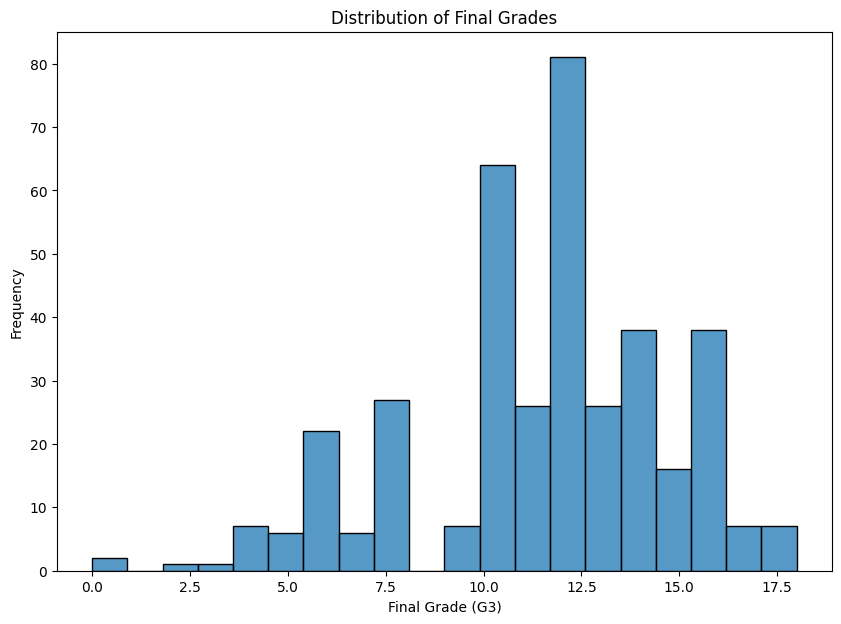

In [22]:
# Exploratory Data Analysis
# Histogram of Final Grades
plt.figure(figsize=(10, 7))
sns.histplot(d3['G3'], bins=20)
plt.title("Distribution of Final Grades")
plt.xlabel("Final Grade (G3)")
plt.ylabel("Frequency")
plt.show()

Based on our heatmap it would seem that having the desire to obtain a higher eduaction(higher_mat) leads to a higher correlation in passing. Despite only a 0.26 correlation, which implies a low to moderate relationship with the pass feature, we believe that this feature still holds significance due to the fact that its one of the higher correlation in relation to the other features. This led us to determining that although in general a 0.26 correlation  would mean that it has at most a moderate relationship with pass, in this study it is more impactful.

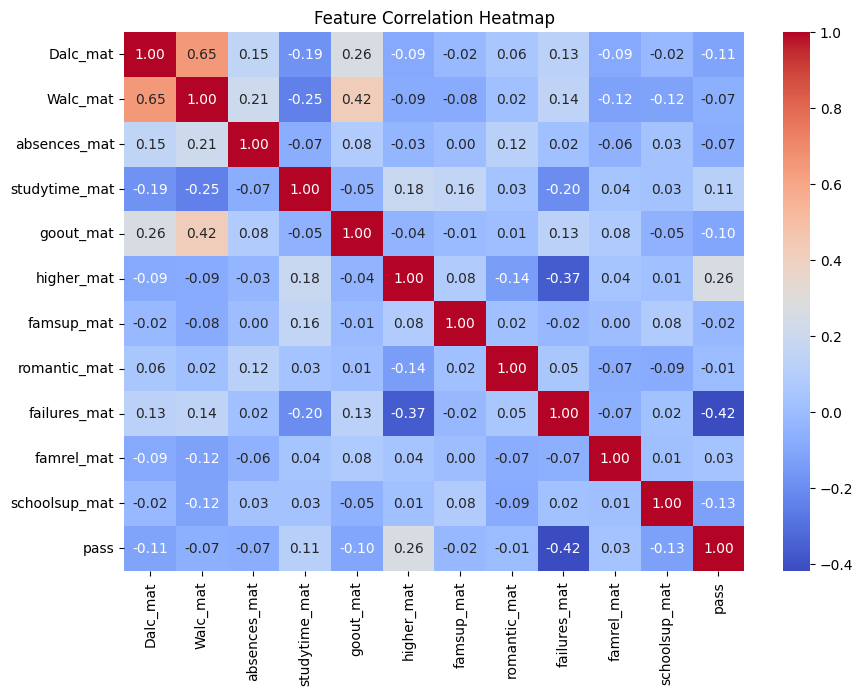

In [23]:
# Heatmap for correlation
plt.figure(figsize=(10, 7))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

Based on our boxplot below, there is a general trend of more fails when one is drinking and more passes when study time is high. There exist other features, however, that doesnt have as clear trend with passing or not like goout_mat where the plot looks exactly the same. This can be attributed to the fact that the effects of that feature, in this example going out, isnt as significant which checks out with our heatmap above. Additionally we have decided to remove the features which only have a binary value to have a cleaner plot

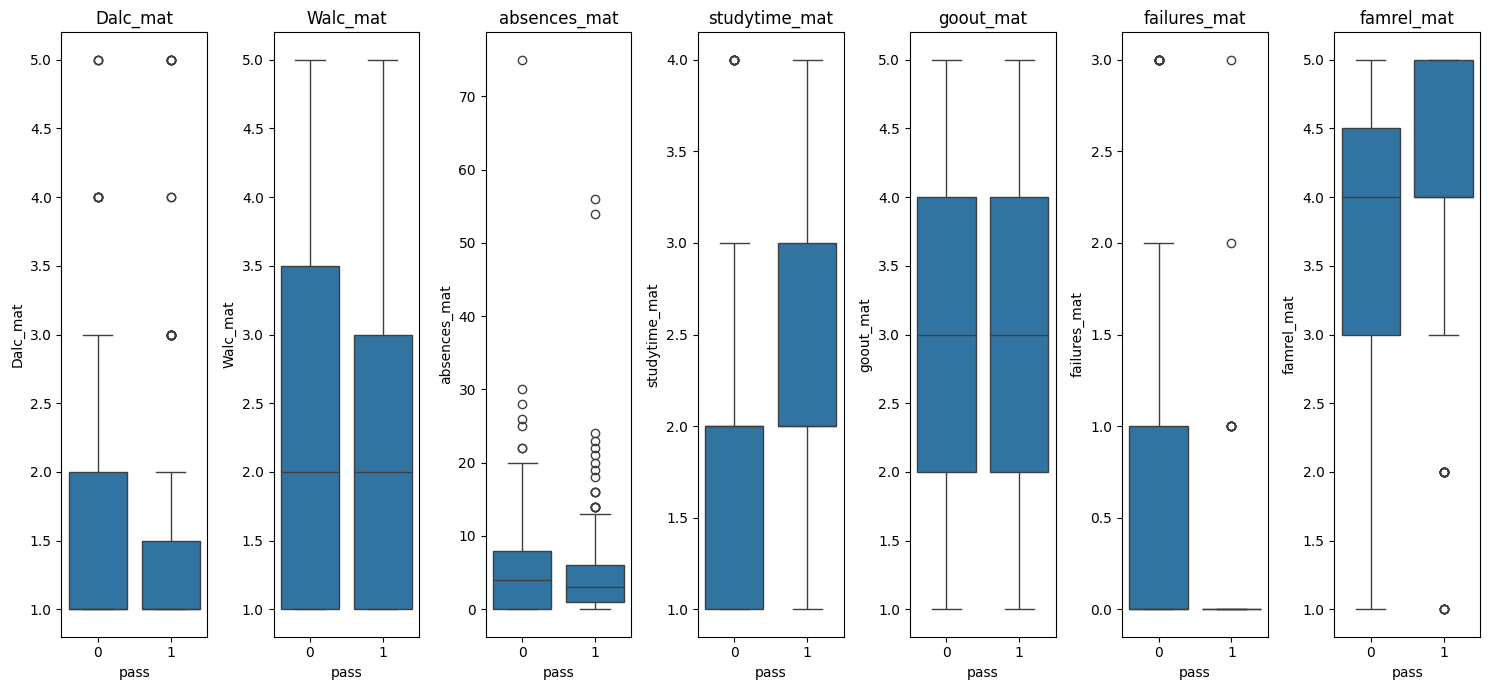

In [24]:
# Boxplot of features by pass/fail
binary_features = ['higher_mat', 'famsup_mat', 'romantic_mat', 'schoolsup_mat']

boxplot_feat = [col for col in X.columns if col not in binary_features]

plt.figure(figsize=(15, 7))
for idx, col in enumerate(boxplot_feat):
    plt.subplot(1, len(boxplot_feat), idx + 1)
    sns.boxplot(x='pass', y=col, data=df)
    plt.title(col)

plt.tight_layout()
plt.show()

In [25]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

<b>Model Training</b> <br>
We have decided on the 3 algorithms: logistic regression, random forest, and support vector machine, to see how each would respond to our chosen data set. Logistic regression being a linear type model, random forest being an ensemble or "trees" type model, and support vector machine being a margin based model, would show how each algorithm would use the data to develop its model. 


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

Hyperparameter Tuning using Random Search

We decided to use Random search for our hyperparameter tuning to ease up on the training time. For Logistic Regression some combinations arent valid for each solver so they were removed to reduce clutter, you can see the error below for them

In [27]:
param_dist_lr = {
    'penalty':['l1','l2','elasticnet','none'],
    'C': np.logspace(-3, 3, 100),
    'solver': ['lbfgs','newton-cg','liblinear','sag','saga'],
    'class_weight': ['balanced'],
    'max_iter'  : [100,1000,2500,5000]
}
random_search_lr = RandomizedSearchCV(
    LogisticRegression(max_iter=1000),
    param_distributions=param_dist_lr,
    n_iter=20,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    random_state=42
)

random_search_lr.fit(X_scaled, y)
best_params = random_search_lr.best_params_
print("Best Logistic Regression Parameters:", best_params)

results_df = pd.DataFrame(random_search_lr.cv_results_)
results_df = results_df[results_df['mean_test_score'].notna()] #remove this line

results_df = results_df[[
    'param_C', 'param_solver', 'param_class_weight',
    'mean_test_score', 'std_test_score', 'rank_test_score'
]]
results_df = results_df.sort_values(by='param_C')


#print("\nHyperparameter Combinations:")
#print(results_df.to_string(index=False))


Best Logistic Regression Parameters: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 100, 'class_weight': 'balanced', 'C': np.float64(0.40370172585965536)}


c:\Users\Hunte\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning:


75 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Hunte\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Hunte\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Hunte\AppD

| param_C   | param_solver | param_class_weight | mean_test_score | std_test_score | rank_test_score |      |
|-----------|--------------|--------------------|-----------------|----------------|-----------------|------|
| 0.002009  | newton-cg    | balanced           | 0.693746        | 0.037456       | 5               |      |
| 0.403702  | saga         | balanced           | 0.748565        | 0.043946       | 1               | best |
| 2.154435  | newton-cg    | balanced           | 0.740738        | 0.045385       | 2               |      |
| 8.69749   | newton-cg    | balanced           | 0.740738        | 0.045385       | 2               |      |
| 53.366992 | lbfgs        | balanced           | 0.740738        | 0.050985       | 2               |      |

<b>Logistic Regression</b>

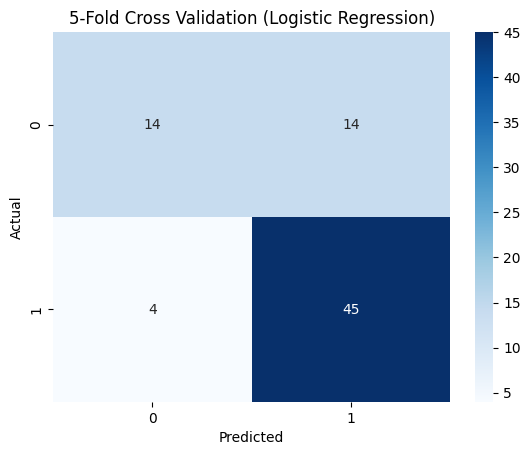

5-Fold Cross Validation (Logistic Regression)
              precision    recall  f1-score   support

           0     0.7778    0.5000    0.6087        28
           1     0.7627    0.9184    0.8333        49

    accuracy                         0.7662        77
   macro avg     0.7702    0.7092    0.7210        77
weighted avg     0.7682    0.7662    0.7516        77



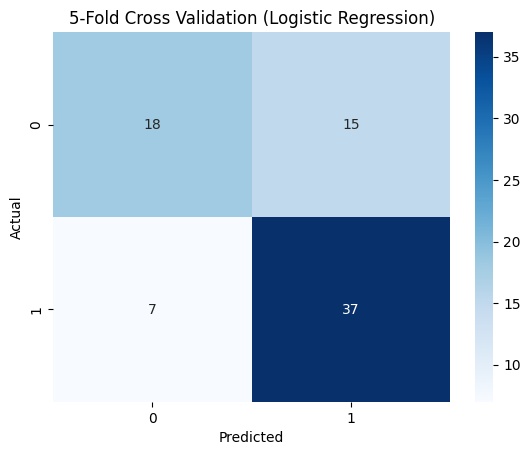

5-Fold Cross Validation (Logistic Regression)
              precision    recall  f1-score   support

           0     0.7200    0.5455    0.6207        33
           1     0.7115    0.8409    0.7708        44

    accuracy                         0.7143        77
   macro avg     0.7158    0.6932    0.6958        77
weighted avg     0.7152    0.7143    0.7065        77



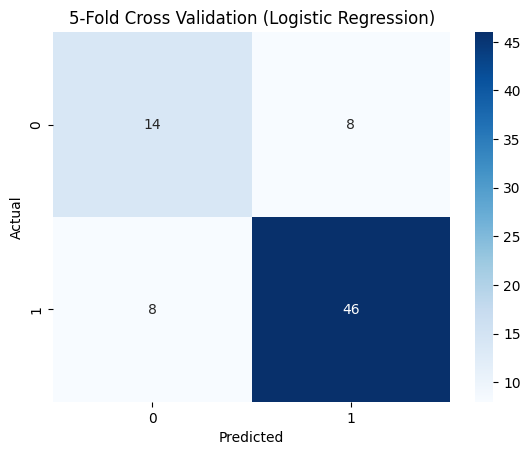

5-Fold Cross Validation (Logistic Regression)
              precision    recall  f1-score   support

           0     0.6364    0.6364    0.6364        22
           1     0.8519    0.8519    0.8519        54

    accuracy                         0.7895        76
   macro avg     0.7441    0.7441    0.7441        76
weighted avg     0.7895    0.7895    0.7895        76



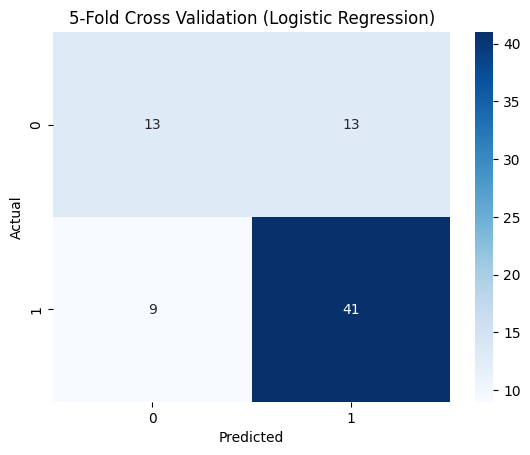

5-Fold Cross Validation (Logistic Regression)
              precision    recall  f1-score   support

           0     0.5909    0.5000    0.5417        26
           1     0.7593    0.8200    0.7885        50

    accuracy                         0.7105        76
   macro avg     0.6751    0.6600    0.6651        76
weighted avg     0.7017    0.7105    0.7040        76



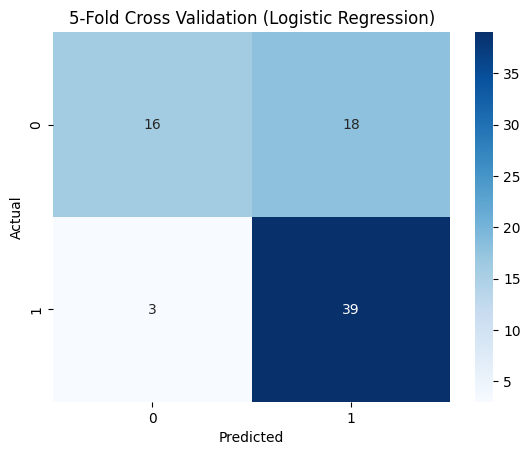

5-Fold Cross Validation (Logistic Regression)
              precision    recall  f1-score   support

           0     0.8421    0.4706    0.6038        34
           1     0.6842    0.9286    0.7879        42

    accuracy                         0.7237        76
   macro avg     0.7632    0.6996    0.6958        76
weighted avg     0.7548    0.7237    0.7055        76



In [28]:
'''
lr_model = LogisticRegression(**best_params)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

conf_mtrx1 = confusion_matrix(y_test, y_pred_lr)

'''
# KFold cross validation (5-fold)
kf = KFold(n_splits=5, shuffle=True, random_state=42)


for train_index, test_index in kf.split(X_scaled):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    model = LogisticRegression(**best_params)
    model.fit(X_train_fold, y_train_fold)
    y_pred_fold = model.predict(X_test_fold)

    conf_mtrx2 = confusion_matrix(y_test_fold, y_pred_fold)


    sns.heatmap(conf_mtrx2, annot=True, fmt='d', cmap='Blues')
    plt.title("5-Fold Cross Validation (Logistic Regression)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print("5-Fold Cross Validation (Logistic Regression)")
    print(classification_report(y_test_fold, y_pred_fold, digits=4))


Random Forest

Hyperparameter Tuning using Random Search

In [29]:
param_dist_rf = {
    'n_estimators': [100, 200, 300, 500, 1000],
    'max_depth': [None, 5, 10, 20, 30], 
    'max_leaf_nodes': [None, 2, 4, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2],
    'class_weight': [None, 'balanced']
}

random_search_rf = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist_rf,
    n_iter=30,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    random_state=42
)

random_search_rf.fit(X_scaled, y)

best_rf_params = random_search_rf.best_params_
print("Best Random Forest Parameters:", best_rf_params)

results_df = pd.DataFrame(random_search_rf.cv_results_)
results_df = results_df[[
    'param_n_estimators', 'param_max_depth', 'param_max_leaf_nodes', 'param_min_samples_split', 'param_min_samples_leaf', 'param_class_weight',
    'mean_test_score', 'std_test_score', 'rank_test_score'
]]
results_df = results_df.sort_values(by='param_n_estimators')


#print("\nHyperparameter Combinations:")
#print(results_df.to_string(index=False))


Best Random Forest Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_leaf_nodes': 6, 'max_depth': None, 'class_weight': None}


| param_n_estimators | param_max_depth | param_max_leaf_nodes | param_min_samples_split | param_min_samples_leaf | param_class_weight | mean_test_score | std_test_score | rank_test_score |      |
|--------------------|-----------------|----------------------|-------------------------|------------------------|--------------------|-----------------|----------------|-----------------|------|
| 100                | 10              | None                 | 10                      | 2                      | balanced           | 0.738278        | 0.049829       | 13              |      |
| 100                | 30              | 2                    | 10                      | 1                      | balanced           | 0.733049        | 0.020428       | 16              |      |
| 100                | 5               | 6                    | 10                      | 1                      | balanced           | 0.732946        | 0.027377       | 21              |      |
| 100                | 10              | None                 | 2                       | 2                      | balanced           | 0.740772        | 0.04339        | 11              |      |
| 100                | 5               | 2                    | 5                       | 2                      | None               | 0.698975        | 0.021529       | 26              |      |
| 100                | 10              | None                 | 2                       | 1                      | None               | 0.748565        | 0.034354       | 10              |      |
| 100                | 20              | None                 | 5                       | 2                      | None               | 0.719891        | 0.031441       | 23              |      |
| 100                | 5               | 2                    | 2                       | 2                      | balanced           | 0.733049        | 0.020428       | 16              |      |
| 100                | 30              | 6                    | 2                       | 1                      | None               | 0.756528        | 0.013614       | 1               |      |
| 200                | None            | 4                    | 2                       | 2                      | balanced           | 0.733014        | 0.03929        | 18              |      |
| 200                | None            | 6                    | 10                      | 1                      | None               | 0.756528        | 0.013614       | 1               | best |
| 200                | 20              | 2                    | 5                       | 2                      | None               | 0.69108         | 0.033966       | 30              |      |
| 300                | None            | 4                    | 2                       | 2                      | balanced           | 0.738278        | 0.030575       | 12              |      |
| 300                | 10              | 2                    | 5                       | 1                      | None               | 0.698941        | 0.023578       | 29              |      |
| 500  | 30   | 6    | 5  | 1 | balanced | 0.73298  | 0.029459 | 19 |   |
| 500  | 10   | 4    | 5  | 2 | None     | 0.751333 | 0.013872 | 8  |   |
| 500  | 30   | 6    | 10 | 2 | None     | 0.75393  | 0.012724 | 5  |   |
| 500  | 10   | 6    | 10 | 2 | None     | 0.75393  | 0.012724 | 5  |   |
| 500  | 5    | 6    | 10 | 2 | balanced | 0.73298  | 0.019663 | 19 |   |
| 500  | 30   | 2    | 10 | 1 | None     | 0.706835 | 0.017195 | 24 |   |
| 500  | 20   | 4    | 2  | 1 | None     | 0.751333 | 0.013872 | 8  |   |
| 500  | None | 2    | 10 | 2 | None     | 0.706835 | 0.017195 | 24 |   |
| 1000 | 20   | 4    | 2  | 2 | None     | 0.756528 | 0.013614 | 1  |   |
| 1000 | 20   | None | 10 | 1 | balanced | 0.735578 | 0.035611 | 15 |   |
| 1000 | None | 2    | 2  | 2 | None     | 0.698975 | 0.018126 | 26 |   |
| 1000 | 10   | None | 5  | 1 | balanced | 0.732946 | 0.024609 | 21 |   |
| 1000 | None | 2    | 10 | 1 | None     | 0.698975 | 0.018126 | 26 |   |
| 1000 | None | None | 5  | 1 | balanced | 0.738175 | 0.025146 | 14 |   |
| 1000 | 10   | 6    | 10 | 1 | None     | 0.756528 | 0.013614 | 1  |   |
| 1000 | None | 6    | 2  | 2 | None     | 0.75393  | 0.012724 | 5  |   |

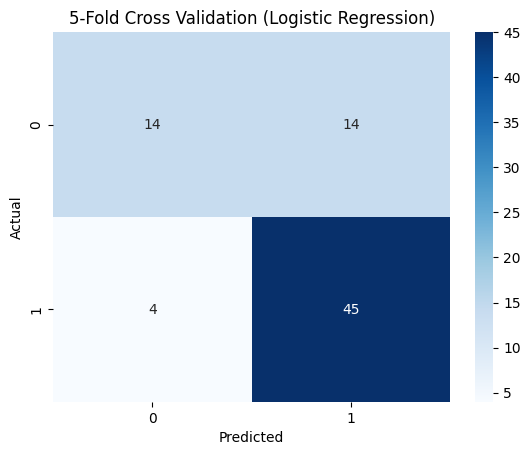

5-Fold Cross Validation (Logistic Regression)
              precision    recall  f1-score   support

           0     0.7778    0.5000    0.6087        28
           1     0.7627    0.9184    0.8333        49

    accuracy                         0.7662        77
   macro avg     0.7702    0.7092    0.7210        77
weighted avg     0.7682    0.7662    0.7516        77



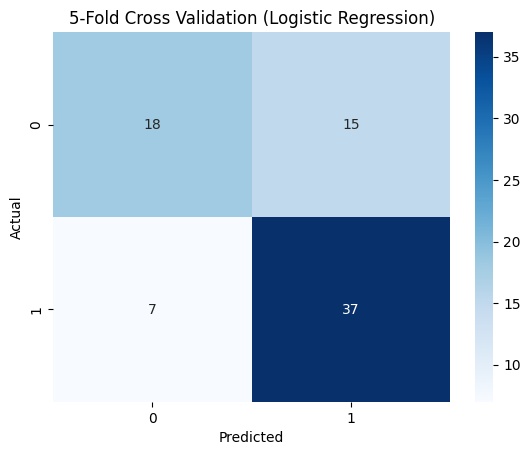

5-Fold Cross Validation (Logistic Regression)
              precision    recall  f1-score   support

           0     0.7200    0.5455    0.6207        33
           1     0.7115    0.8409    0.7708        44

    accuracy                         0.7143        77
   macro avg     0.7158    0.6932    0.6958        77
weighted avg     0.7152    0.7143    0.7065        77



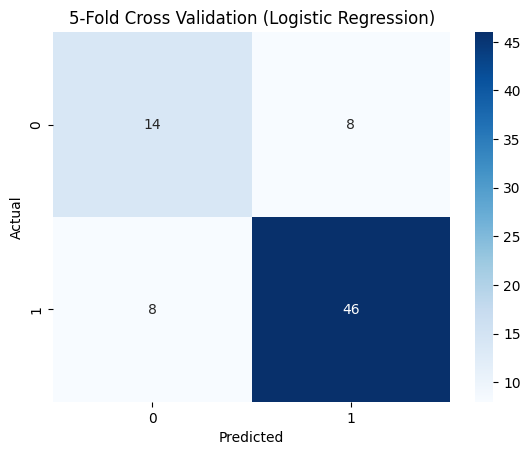

5-Fold Cross Validation (Logistic Regression)
              precision    recall  f1-score   support

           0     0.6364    0.6364    0.6364        22
           1     0.8519    0.8519    0.8519        54

    accuracy                         0.7895        76
   macro avg     0.7441    0.7441    0.7441        76
weighted avg     0.7895    0.7895    0.7895        76



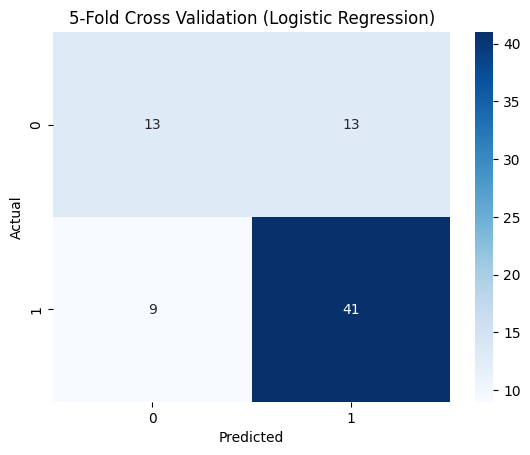

5-Fold Cross Validation (Logistic Regression)
              precision    recall  f1-score   support

           0     0.5909    0.5000    0.5417        26
           1     0.7593    0.8200    0.7885        50

    accuracy                         0.7105        76
   macro avg     0.6751    0.6600    0.6651        76
weighted avg     0.7017    0.7105    0.7040        76



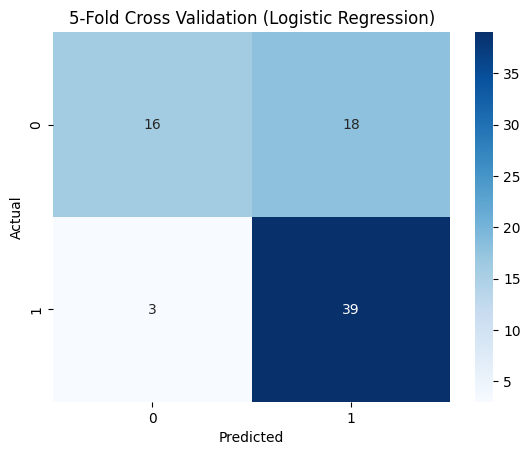

5-Fold Cross Validation (Logistic Regression)
              precision    recall  f1-score   support

           0     0.8421    0.4706    0.6038        34
           1     0.6842    0.9286    0.7879        42

    accuracy                         0.7237        76
   macro avg     0.7632    0.6996    0.6958        76
weighted avg     0.7548    0.7237    0.7055        76



In [30]:
'''
rf_model = RandomForestClassifier(**best_rf_params, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

conf_mtrx1 = confusion_matrix(y_test, y_pred_rf)
'''

# KFold cross validation (5-fold)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
y_true_all = []
y_pred_all = []

for train_index, test_index in kf.split(X_scaled):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    rf_model = RandomForestClassifier(**best_rf_params, random_state=42)
    model.fit(X_train_fold, y_train_fold)
    y_pred_fold = model.predict(X_test_fold)

    y_true_all.extend(y_test_fold)
    y_pred_all.extend(y_pred_fold)
    
    conf_mtrx2 = confusion_matrix(y_test_fold, y_pred_fold)


    sns.heatmap(conf_mtrx2, annot=True, fmt='d', cmap='Blues')
    plt.title("5-Fold Cross Validation (Logistic Regression)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print("5-Fold Cross Validation (Logistic Regression)")
    print(classification_report(y_test_fold, y_pred_fold, digits=4))

Support Vector Machine (SVM)

Hyperparameter Tuning using Random Search

In [31]:
param_dist_svm = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto', 0.01, 0.001, 0.0001],
    'kernel': ['rbf'],
    'class_weight': ['balanced']
}

random_search_svm = RandomizedSearchCV(
    SVC(probability=True, random_state=42),
    param_distributions=param_dist_svm,
    n_iter=20,
    scoring='accuracy',
    cv=5,
    random_state=42,
    n_jobs=-1
)

random_search_svm.fit(X_scaled, y)
best_svm_params = random_search_svm.best_params_
print("Best SVM Parameters:", best_svm_params)


results_df = pd.DataFrame(random_search_svm.cv_results_)
results_df = results_df[[
    'param_C', 'param_gamma', 'param_kernel', 'param_class_weight',
    'mean_test_score', 'std_test_score', 'rank_test_score'
]]
results_df = results_df.sort_values(by='param_C')


#print("\nHyperparameter Combinations:")
#print(results_df.to_string(index=False))

Best SVM Parameters: {'kernel': 'rbf', 'gamma': 0.001, 'class_weight': 'balanced', 'C': 100}


| param_C | param_gamma | param_kernel | param_class_weight | mean_test_score | std_test_score | rank_test_score |   |
|---------|-------------|--------------|--------------------|-----------------|----------------|-----------------|---|
| 0.1     | scale       | rbf          | balanced           | 0.685783        | 0.022979       | 10              |   |
| 0.1     | auto        | rbf          | balanced           | 0.685817        | 0.025382       | 9               |   |
| 0.1     | 0.001       | rbf          | balanced           | 0.625666        | 0.005156       | 18              |   |
| 0.1     | 0.01        | rbf          | balanced           | 0.680588        | 0.029778       | 12              |   |
| 0.1     | 0.0001      | rbf          | balanced           | 0.625666        | 0.005156       | 18              |   |
| 1       | scale       | rbf          | balanced           | 0.724983        | 0.047822       | 5               |   |
| 1       | 0.0001      | rbf          | balanced           | 0.520403        | 0.124106       | 20              |   |
| 1       | 0.001       | rbf          | balanced           | 0.688448        | 0.019659       | 8               |   |
| 10      | 0.01        | rbf          | balanced           | 0.751128        | 0.037302       | 3               |   |
| 10      | auto        | rbf          | balanced           | 0.672727        | 0.031207       | 13              |   |
| 10      | 0.001       | rbf          | balanced           | 0.711825        | 0.045034       | 6               |   |
| 100     | auto        | rbf          | balanced           | 0.659638        | 0.043306       | 14              |   |
| 100     | scale       | rbf          | balanced           | 0.657006        | 0.046044       | 15              |   |
| 100     | 0.01        | rbf          | balanced           | 0.709296        | 0.025364       | 7               |   |
| 100  | 0.001  | rbf | balanced | 0.753759 | 0.037593 | 1  | best |
| 1000 | 0.001  | rbf | balanced | 0.751128 | 0.037302 | 3  |      |
| 1000 | scale  | rbf | balanced | 0.630998 | 0.041489 | 17 |      |
| 1000 | 0.01   | rbf | balanced | 0.683151 | 0.042488 | 11 |      |
| 1000 | auto   | rbf | balanced | 0.636227 | 0.042326 | 16 |      |
| 1000 | 0.0001 | rbf | balanced | 0.753759 | 0.037593 | 1  |      |

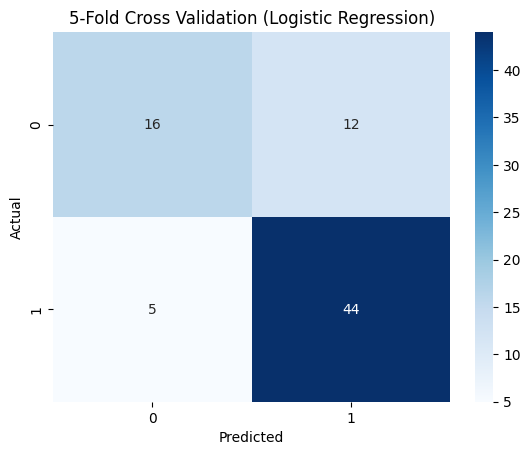

5-Fold Cross Validation (Logistic Regression)
              precision    recall  f1-score   support

           0     0.7619    0.5714    0.6531        28
           1     0.7857    0.8980    0.8381        49

    accuracy                         0.7792        77
   macro avg     0.7738    0.7347    0.7456        77
weighted avg     0.7771    0.7792    0.7708        77

              precision    recall  f1-score   support

           0     0.7619    0.5714    0.6531        28
           1     0.7857    0.8980    0.8381        49

    accuracy                         0.7792        77
   macro avg     0.7738    0.7347    0.7456        77
weighted avg     0.7771    0.7792    0.7708        77



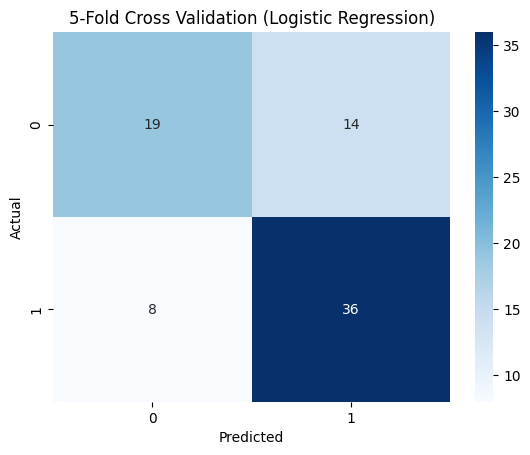

5-Fold Cross Validation (Logistic Regression)
              precision    recall  f1-score   support

           0     0.7037    0.5758    0.6333        33
           1     0.7200    0.8182    0.7660        44

    accuracy                         0.7143        77
   macro avg     0.7119    0.6970    0.6996        77
weighted avg     0.7130    0.7143    0.7091        77

              precision    recall  f1-score   support

           0     0.7292    0.5738    0.6422        61
           1     0.7547    0.8602    0.8040        93

    accuracy                         0.7468       154
   macro avg     0.7419    0.7170    0.7231       154
weighted avg     0.7446    0.7468    0.7399       154



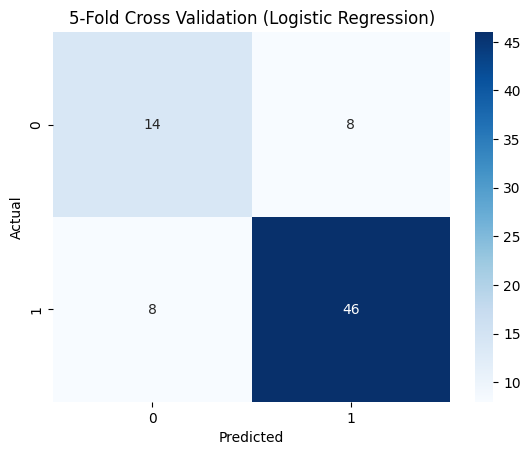

5-Fold Cross Validation (Logistic Regression)
              precision    recall  f1-score   support

           0     0.6364    0.6364    0.6364        22
           1     0.8519    0.8519    0.8519        54

    accuracy                         0.7895        76
   macro avg     0.7441    0.7441    0.7441        76
weighted avg     0.7895    0.7895    0.7895        76

              precision    recall  f1-score   support

           0     0.7000    0.5904    0.6405        83
           1     0.7875    0.8571    0.8208       147

    accuracy                         0.7609       230
   macro avg     0.7437    0.7238    0.7307       230
weighted avg     0.7559    0.7609    0.7558       230



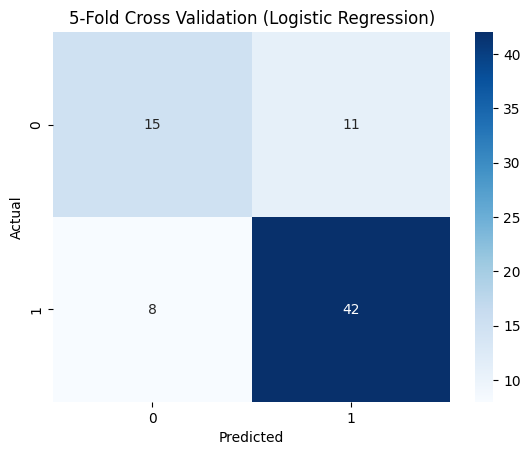

5-Fold Cross Validation (Logistic Regression)
              precision    recall  f1-score   support

           0     0.6522    0.5769    0.6122        26
           1     0.7925    0.8400    0.8155        50

    accuracy                         0.7500        76
   macro avg     0.7223    0.7085    0.7139        76
weighted avg     0.7445    0.7500    0.7460        76

              precision    recall  f1-score   support

           0     0.6882    0.5872    0.6337       109
           1     0.7887    0.8528    0.8195       197

    accuracy                         0.7582       306
   macro avg     0.7385    0.7200    0.7266       306
weighted avg     0.7529    0.7582    0.7533       306



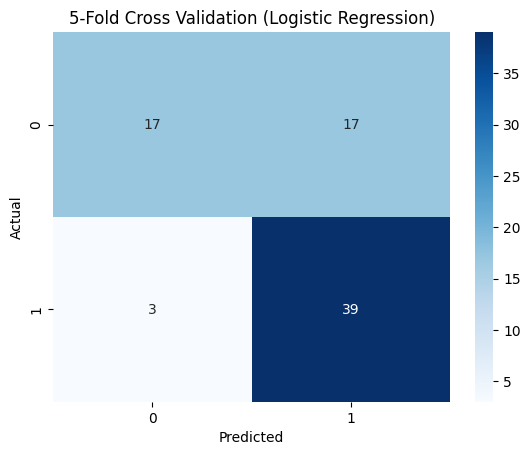

5-Fold Cross Validation (Logistic Regression)
              precision    recall  f1-score   support

           0     0.8500    0.5000    0.6296        34
           1     0.6964    0.9286    0.7959        42

    accuracy                         0.7368        76
   macro avg     0.7732    0.7143    0.7128        76
weighted avg     0.7651    0.7368    0.7215        76

              precision    recall  f1-score   support

           0     0.7168    0.5664    0.6328       143
           1     0.7695    0.8661    0.8150       239

    accuracy                         0.7539       382
   macro avg     0.7432    0.7163    0.7239       382
weighted avg     0.7498    0.7539    0.7468       382



In [32]:
'''
svm_model = SVC(**best_svm_params, probability=True, random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

conf_mtrx1 = confusion_matrix(y_test, y_pred_svm)
'''

# KFold cross validation (5-fold)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
y_true_all = []
y_pred_all = []

for train_index, test_index in kf.split(X_scaled):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    model = SVC(**best_svm_params, probability=True, random_state=42)
    model.fit(X_train_fold, y_train_fold)
    y_pred_fold = model.predict(X_test_fold)

    y_true_all.extend(y_test_fold)
    y_pred_all.extend(y_pred_fold)

    conf_mtrx2 = confusion_matrix(y_test_fold, y_pred_fold)


    sns.heatmap(conf_mtrx2, annot=True, fmt='d', cmap='Blues')
    plt.title("5-Fold Cross Validation (Logistic Regression)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print("5-Fold Cross Validation (Logistic Regression)")
    print(classification_report(y_test_fold, y_pred_fold, digits=4))
    print(classification_report(y_true_all, y_pred_all, digits=4))

<b>Analysis</b>


 ANOVA F-test
Dalc_mat: F=4.78, p=0.0293
Walc_mat: F=1.73, p=0.1892
absences_mat: F=1.98, p=0.1603
studytime_mat: F=4.49, p=0.0348
goout_mat: F=4.22, p=0.0406
higher_mat: F=28.00, p=0.0000
famsup_mat: F=0.17, p=0.6786
romantic_mat: F=0.03, p=0.8733
failures_mat: F=80.97, p=0.0000
famrel_mat: F=0.38, p=0.5371
schoolsup_mat: F=6.11, p=0.0139


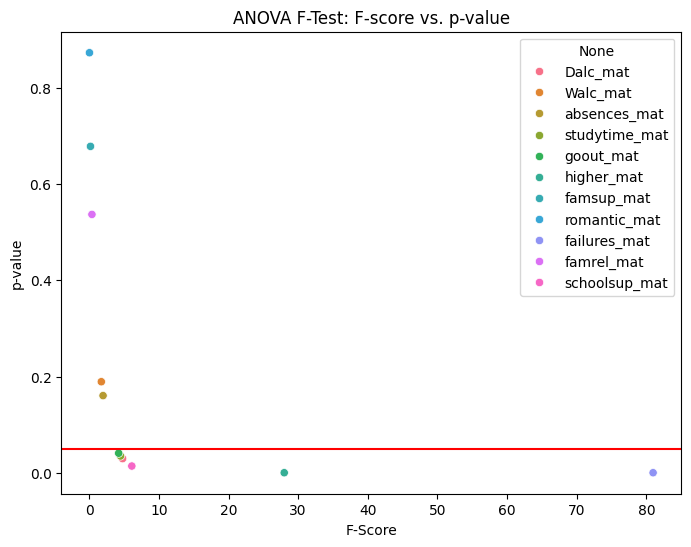

In [33]:
# Multivariate Analysis 
print("\n ANOVA F-test")
f_stat, p_val = f_classif(X, y)
for i, col in enumerate(X.columns):
    print(f"{col}: F={f_stat[i]:.2f}, p={p_val[i]:.4f}")

anova_df = pd.DataFrame({
    'Feature': X.columns,
    'F-Score': f_stat,
    'p-value': p_val
})

plt.figure(figsize=(8, 6))
sns.scatterplot(x=f_stat, y=p_val, hue=X.columns)
plt.axhline(0.05, color='red', linestyle='-', label='p = 0.05')
plt.xlabel("F-Score")
plt.ylabel("p-value")
plt.title("ANOVA F-Test: F-score vs. p-value")
plt.show()

Based on our ANOVA test (the features below the red line) we can see that the significant features are:
1. Dalc_mat
2. studytime_mat
3. goout_mat
4. higher_mat
5. failures_mat
6. schoolsup_mat

while the insignificant ones are:
1. Walc_mat
2. absences_mat
3. famsup_mat
4. romantic_mat
5. famrel_mat

Now that we know our significant features, a combination of the them would lead to the best or worst academic performance. 
<br>i.e. low Dalc_mat, high studytime_mat, low goout_mat, etc for the best academic performance and vice versa for the worst.

In [34]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_scaled, y)
print("\nLogistic Regression Coefficients:")
for feature, coef in zip(X.columns, lr.coef_[0]):
    print(f"{feature}: {coef:.4f}")
df_lr = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr.coef_[0]
})
fig = px.bar(df_lr, x='Feature', y='Coefficient', title='Logistic Regression Coefficients', color='Coefficient')
fig.show()


Logistic Regression Coefficients:
Dalc_mat: -0.1490
Walc_mat: 0.1604
absences_mat: -0.0977
studytime_mat: 0.0337
goout_mat: -0.1519
higher_mat: 0.5763
famsup_mat: -0.0839
romantic_mat: 0.1017
failures_mat: -1.2048
famrel_mat: -0.0095
schoolsup_mat: -0.2703


<b>Logistic Regression</b> works by outputting probability based on the feature, based on our plot above we can see that Walc_mat, studytime_mat, higher_mat, and romantic_mat has positive coefficients, which means that an increase in these features would have a positive increase in the probability of a student passing. Some features have a surprising value, specifically walc_mat and schoolsup_mat. A positive Walc_mat coefficiant could suggest that there is a coincidence in the data, a student already passing would celebrate by drinking on the weekend etc. While a negative schoolsup_mat coefficient could suggest that those who needs/applied for school support are already struggling to begin with, which would reflect in the dataset.  

In [35]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_scaled, y)
importances_rf = rf.feature_importances_
print("Random Forest Feature Importances:")
for feature, importance in zip(X.columns, importances_rf):
    print(f"{feature}: {importance:.4f}")

df_rf = pd.DataFrame({
    'Feature': X.columns, 
    'Importance': importances_rf
})
fig = px.bar(df_rf, x='Feature', y='Importance', title='Random Forest Feature Importance')
fig.show()

Random Forest Feature Importances:
Dalc_mat: 0.0579
Walc_mat: 0.0979
absences_mat: 0.1879
studytime_mat: 0.0947
goout_mat: 0.1229
higher_mat: 0.0337
famsup_mat: 0.0450
romantic_mat: 0.0499
failures_mat: 0.1725
famrel_mat: 0.0948
schoolsup_mat: 0.0428


<b>Random Forest</b> works best at discovering patterns that arent obvious at a glance. This can be seen in how it places importance on the features. absences_mat, failures_mat, and goout_mat are the top 3 features which means that if their value is high it would have a higher impact on the probability (since the features are negative itll lead to a worse probability). An interesting behavior here is that while in Logistic Regression, higher_mat was placed high. In Random Forest its place as the least important. This could be due to the fact that the pattern connected to it has already been discovered through a different feature, meaning it becomes redundant. While famrel_mat is placed somewhat high in the importance list, due to the fact that there is a hidden pattern that makes famrel_mat affect the probaility of getting a good academic performance.

In [36]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(svm_model, random_state=42).fit(X_test, y_test)

eli5.show_weights(perm, feature_names=X.columns.tolist())

Weight,Feature
0.1091 ± 0.0352,failures_mat
0.0545 ± 0.0844,higher_mat
0.0468 ± 0.0127,schoolsup_mat
0 ± 0.0000,famrel_mat
0 ± 0.0000,romantic_mat
0 ± 0.0000,famsup_mat
0 ± 0.0000,goout_mat
0 ± 0.0000,studytime_mat
0 ± 0.0000,absences_mat
0 ± 0.0000,Walc_mat


<b>Support Vector Machine</b> works by finding the boundary between 2 classes, in this case pass and fail. Unlike the previous 2 algorithms, it does not have a coefficient or importance that we can output to see how it processes the features. so we decided to use permutation importance instead to determine which features impacts the prediction when the data of a single feature is shuffled and evaluated against the original prediction. In this case we can see that failures_mat have the highest loss in accuracy at 11% +- 3.52% when the feature is shuffled, followed by higher_mat and schoolsup_mat.

<b> References </b> <br>
<br>
Communications Team. (2022, March 8). *10 Factors Affecting Academic Performance Among Higher Secondary School Students*. <br> 
Global Indian International School Abu Dhabi. https://globalindianschool.org/abudhabi/blog-details/factors-affecting-academic-performance <br>
<br>
GeeksforGeeks. (2025, July 23). Machine Learning Explainability using Permutation Importance. GeeksforGeeks. https://www.geeksforgeeks.org/machine-learning/machine-learning-explainability-using-permutation-importance/<br>
<br>
Hashemi-Pour, C., & Wigmore, I. (2024, July 29). *What are machine learning algorithms? 12 types explained*. <br> 
TechTarget. https://www.techtarget.com/whatis/definition/machine-learning-algorithm‌ <br>
<br>
IBM. (2021, September 22). *What is machine learning?*. IBM. https://www.ibm.com/think/topics/machine-learning <br>